In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import spacy
warnings.filterwarnings("ignore")
import random

import nltk
from nltk.stem import WordNetLemmatizer

import re

from spacy.tokens import DocBin

from tqdm import tqdm

In [20]:
train_data = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\train.csv")
features = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\features.csv")
patient_notes = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\patient_notes.csv")

### CASE - 6

In [21]:
case_6_features = features[features["case_num"] == 6]
case_6_features

,feature_num,case_num,feature_text
87,600,6,Subjective-fevers
88,601,6,Male
89,602,6,17-year
90,603,6,Recent-upper-respiratory-symptoms
91,604,6,Worse-with-deep-breath-OR-pleuritic
92,605,6,Exercise-induced-asthma
93,606,6,Chest-pain
94,607,6,Duration-x-1-day
95,608,6,No-shortness-of-breath
96,609,6,Recent-heavy-lifting-at-work-OR-recent-rock-cl...


In [22]:
case_6_pn = patient_notes[patient_notes["case_num"] ==  6]
case_6_pn

,pn_num,case_num,pn_history
27101,60000,6,HPI:17 Y.O. M. CO. chest pain.\r\n-started 1 ...
27102,60001,6,Mr. Smith is a 17 yo M who comes in complainin...
27103,60002,6,Kane Smith 17 yo M presenting with chest pain ...
27104,60003,6,17 y old m complains of chest pain since yeste...
27105,60004,6,17 y/o male with ches pain. Pt woke up yesterd...
...,...,...,...
28693,61776,6,17 YO M PRESENTED TO ED WITH C/O SEVEVER LEFT ...
28694,61777,6,Patient is a 17 yo male who presents with 1 da...
28695,61778,6,17 yo male presenting with left-sided chest pa...
28696,61779,6,17 y / m present swith left sided dchest pain ...


In [23]:
case_6_train = train_data[train_data["case_num"] == 6]
case_6_train = case_6_train[case_6_train.annotation != '[]']
case_6_train

,id,case_num,pn_num,feature_num,annotation,location
8700,60004_600,6,60004,600,['feeling febrile'],['293 308']
8701,60004_601,6,60004,601,['male'],['7 11']
8702,60004_602,6,60004,602,['17 y/o'],['0 6']
8703,60004_603,6,60004,603,['recently had running nose'],['266 291']
8704,60004_604,6,60004,604,['8/10 with deep inspiration'],['153 179']
...,...,...,...,...,...,...
9894,61768_606,6,61768,606,['chest pain'],['56 66']
9895,61768_607,6,61768,607,['for one day'],['67 78']
9896,61768_608,6,61768,608,['negative shortness of breath'],['413 421;460 479']
9898,61768_610,6,61768,610,['albuteral inhaler without relief'],['374 406']


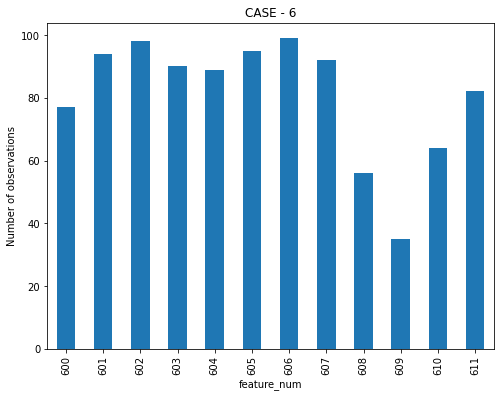

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
case_6_train.groupby("feature_num").size().plot.bar()
plt.title("CASE - 6")
plt.ylabel("Number of observations")
plt.show()

### Over Sampling for CASE - 6

In [25]:
pn_dict = {}
for idx, row in case_6_pn.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

In [26]:
new_annotation = []
for case_id in case_6_features['case_num'].unique():
    
    all_pn_id = set(case_6_pn[case_6_pn['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in case_6_features[case_6_features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(case_6_train[case_6_train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = case_6_train[case_6_train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
     #   break
    break
    # break to get sample results quickly

In [27]:
len(new_annotation)

11987

In [28]:
df=pd.DataFrame(new_annotation)
df.head()

,0,1,2,3,4,5
0,61440_600,6,61440,600,"[subjective fever, fever]","[321 337, 332 337]"
1,61441_600,6,61441,600,[warmth],[359 365]
2,61442_600,6,61442,600,[felt warm],[308 317]
3,61443_600,6,61443,600,[fever],[177 182]
4,61449_600,6,61449,600,[fever],[331 336]


In [29]:
df.columns=['id','case_num','pn_num','feature_num','annotation','location']
df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,61440_600,6,61440,600,"[subjective fever, fever]","[321 337, 332 337]"
1,61441_600,6,61441,600,[warmth],[359 365]
2,61442_600,6,61442,600,[felt warm],[308 317]
3,61443_600,6,61443,600,[fever],[177 182]
4,61449_600,6,61449,600,[fever],[331 336]


In [30]:
df["location"] = df["location"].apply(str)
df["annotation"] = df["annotation"].apply(str)

df["annotation"] = df.annotation.str.replace('[','')
df["annotation"] = df.annotation.str.replace(']','')
df["location"] = df.location.str.replace('[','')
df["location"] = df.location.str.replace(']','')

df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,61440_600,6,61440,600,"'subjective fever', 'fever'","'321 337', '332 337'"
1,61441_600,6,61441,600,'warmth','359 365'
2,61442_600,6,61442,600,'felt warm','308 317'
3,61443_600,6,61443,600,'fever','177 182'
4,61449_600,6,61449,600,'fever','331 336'


In [31]:
df = df[(df["feature_num"] == 603)|(df["feature_num"] == 609)|(df["feature_num"] == 610)][['pn_num','annotation',"location","feature_num"]]
df.shape

(1648, 4)

In [47]:
df.loc[df["annotation"] == "'rhinorrhea', 'congestion', 'congestion, rhinorrhea'","annotation"] = "'rhinorrhea', 'congestion', 'congestion  rhinorrhea'"
df.loc[df["annotation"] == "'rhinorrhea', 'nasal congestion', 'congestion', 'congestion, rhinorrhea'","annotation"] = "'rhinorrhea', 'nasal congestion', 'congestion', 'congestion  rhinorrhea'"

In [38]:
df.loc[df["annotation"] == "'stuffy, runny nose', 'runny nose'","annotation"] = "'stuffy  runny nose', 'runny nose'"

In [34]:
df.loc[df["annotation"] == "'congestion', 'congestion, rhinorrhea', 'rhinorrhea'","annotation"] = "'congestion', 'congestion  rhinorrhea', 'rhinorrhea'"
df.loc[df["annotation"] == "'congestion', 'nasal congestion', 'congestion, rhinorrhea', 'rhinorrhea'","annotation"] = "'congestion', 'nasal congestion', 'congestion  rhinorrhea', 'rhinorrhea'"
df.loc[df["annotation"] == "'runny nose', 'stuffy, runny nose'","annotation"] = "'runny nose', 'stuffy  runny nose'"
df.loc[df["annotation"] == "'congestion, rhinorrhea', 'nasal congestion', 'rhinorrhea', 'congestion'","annotation"] = "'congestion  rhinorrhea', 'nasal congestion', 'rhinorrhea', 'congestion'"
df.loc[df["annotation"] == "'congestion, rhinorrhea', 'rhinorrhea', 'congestion'","annotation"] = "'congestion  rhinorrhea', 'rhinorrhea', 'congestion'"

In [48]:
df = (df.set_index(["pn_num","feature_num"]) 
   .apply(lambda col: col.str.split(",").explode())
   .reset_index()
   .reindex(df.columns, axis=1))


In [49]:
df["start_location"] = df["location"].apply(lambda x: x.split()[0][1:])
df["end_location"] = df["location"].apply(lambda x: x.split()[-1][:-1])
df

,pn_num,annotation,location,feature_num,start_location,end_location
0,61440,'stuffy nose','341 352',603,341,352
1,61442,'stuffy nose','343 354',603,343,354
2,61443,'runny nose','165 175',603,165,175
3,61444,'stuffy nose','189 200',603,189,200
4,61449,'runny nose','319 329',603,319,329
...,...,...,...,...,...,...
2375,61380,'albuterol inhaler without relief','414 446',610,414,446
2376,61381,'not relieved by albuterol','288 313',610,288,313
2377,61382,'albuterol inhaler did not help','186 216',610,186,216
2378,61411,'albuterol did not help','396 418',610,396,418


In [50]:
df_603 = df[df["feature_num"] == 603].sample(n = 100, random_state = 0)
df_603.shape

(100, 6)

In [51]:
df_609 = df[df["feature_num"] == 609].sample(n = 140, random_state = 0)
df_609.shape

(140, 6)

In [52]:
df_610 = df[df["feature_num"] == 610].sample(n = 100, random_state = 0)
df_610.shape

(100, 6)

In [53]:
df_609

,pn_num,annotation,location,feature_num,start_location,end_location
1718,60066,'rock climb','923 933',609,923,933
1709,60044,'rock climbing','648 661',609,648,661
1536,61477,'rock climb','773 783',609,773,783
1553,61517,'rock climbing','216 229',609,216,229
2027,60845,'rockclimbing','895 907',609,895,907
...,...,...,...,...,...,...
2123,61049,'rock climb','718 728',609,718,728
1732,60089,'rock climbing','398 411',609,398,411
1980,60698,'rock climbing','778 791',609,778,791
2124,61053,'rock climb','526 536',609,526,536


### Case - 6 Train data

In [54]:
case_6_train = case_6_train[['pn_num','annotation',"location","feature_num"]]

In [55]:
case_6_train["annotation"] = case_6_train.annotation.str.replace('[','')
case_6_train["annotation"] = case_6_train.annotation.str.replace(']','')
case_6_train["location"] = case_6_train.location.str.replace('[','')
case_6_train["location"] = case_6_train.location.str.replace(']','')

case_6_train

,pn_num,annotation,location,feature_num
8700,60004,'feeling febrile','293 308',600
8701,60004,'male','7 11',601
8702,60004,'17 y/o','0 6',602
8703,60004,'recently had running nose','266 291',603
8704,60004,'8/10 with deep inspiration','153 179',604
...,...,...,...,...
9894,61768,'chest pain','56 66',606
9895,61768,'for one day','67 78',607
9896,61768,'negative shortness of breath','413 421;460 479',608
9898,61768,'albuteral inhaler without relief','374 406',610


In [57]:
case_6_train.loc[case_6_train["annotation"] == "'albuterol, but didnt help'","annotation"] = "'albuterol  but didnt help'"
case_6_train.loc[case_6_train["annotation"] == "'runny nose, with whitish yellowish secretions'","annotation"] = "'runny nose  with whitish yellowish secretions'"
case_6_train.loc[case_6_train["annotation"] == "'recent URI', 'nasal stuffines, rhinorrhea, for 3-4 day'","annotation"] = "'recent URI', 'nasal stuffines  rhinorrhea  for 3-4 day'"
case_6_train.loc[case_6_train["annotation"] == "'congestion, rhinorrhea'","annotation"] = "'congestion  rhinorrhea'"
case_6_train.loc[case_6_train["annotation"] == "'stuffy, runny nose'","annotation"] = "'stuffy  runny nose'"
case_6_train.loc[case_6_train["annotation"] == "'pain, worse w/ inhalation', 'worse w/ inhalation'","annotation"] = "'pain  worse w/ inhalation', 'worse w/ inhalation'"
case_6_train.loc[case_6_train["annotation"] == "'No shortness of breath,'","annotation"] = "'No shortness of breath '"

In [58]:
case_6_train = (case_6_train.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(case_6_train.columns, axis=1))
case_6_train

,pn_num,annotation,location,feature_num
0,60004,'feeling febrile','293 308',600
1,60004,'male','7 11',601
2,60004,'17 y/o','0 6',602
3,60004,'recently had running nose','266 291',603
4,60004,'8/10 with deep inspiration','153 179',604
...,...,...,...,...
1100,61768,'for one day','67 78',607
1101,61768,'negative shortness of breath','413 421;460 479',608
1102,61768,'albuteral inhaler without relief','374 406',610
1103,61768,'sharp','139 144',611


In [59]:
case_6_train["start_location"] = case_6_train["location"].apply(lambda x: x.split()[0][1:])
case_6_train["end_location"] = case_6_train["location"].apply(lambda x: x.split()[-1][:-1])
case_6_train

,pn_num,annotation,location,feature_num,start_location,end_location
0,60004,'feeling febrile','293 308',600,293,308
1,60004,'male','7 11',601,7,11
2,60004,'17 y/o','0 6',602,0,6
3,60004,'recently had running nose','266 291',603,266,291
4,60004,'8/10 with deep inspiration','153 179',604,153,179
...,...,...,...,...,...,...
1100,61768,'for one day','67 78',607,67,78
1101,61768,'negative shortness of breath','413 421;460 479',608,413,479
1102,61768,'albuteral inhaler without relief','374 406',610,374,406
1103,61768,'sharp','139 144',611,139,144


In [60]:
case_6 = pd.concat([case_6_train,df_603, df_609, df_610])
case_6.shape

(1445, 6)

In [61]:
case_6 = case_6.merge(patient_notes, on='pn_num', how='left')
case_6

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history
0,60004,'feeling febrile','293 308',600,293,308,6,17 y/o male with ches pain. Pt woke up yesterd...
1,60004,'male','7 11',601,7,11,6,17 y/o male with ches pain. Pt woke up yesterd...
2,60004,'17 y/o','0 6',602,0,6,6,17 y/o male with ches pain. Pt woke up yesterd...
3,60004,'recently had running nose','266 291',603,266,291,6,17 y/o male with ches pain. Pt woke up yesterd...
4,60004,'8/10 with deep inspiration','153 179',604,153,179,6,17 y/o male with ches pain. Pt woke up yesterd...
...,...,...,...,...,...,...,...,...
1440,60290,'albuterol inhaler with no relief','397 429',610,397,429,6,"17yo M who presents with sharp, severe left-si..."
1441,61235,'albuterol inhaler without relief','396 428',610,396,428,6,17 yo m presents to the office with 1 day hx o...
1442,60227,'albuterol inhaler have not helped','265 298',610,265,298,6,Kane Smith is a 17 yo M who presents with shar...
1443,60584,'Albuterol inhaler with no relief','255 287',610,255,287,6,Kane Smith is a 17yo M presenting with chest p...


In [62]:
case_6["New_annotation"] = case_6.apply(lambda x: x.pn_history[int(x.start_location):int(x.end_location)],axis=1)
case_6.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,60004,'feeling febrile','293 308',600,293,308,6,17 y/o male with ches pain. Pt woke up yesterd...,feeling febrile
1,60004,'male','7 11',601,7,11,6,17 y/o male with ches pain. Pt woke up yesterd...,male
2,60004,'17 y/o','0 6',602,0,6,6,17 y/o male with ches pain. Pt woke up yesterd...,17 y/o
3,60004,'recently had running nose','266 291',603,266,291,6,17 y/o male with ches pain. Pt woke up yesterd...,recently had running nose
4,60004,'8/10 with deep inspiration','153 179',604,153,179,6,17 y/o male with ches pain. Pt woke up yesterd...,8/10 with deep inspiration


In [63]:
case_6["New_annotation"] = case_6.apply(lambda x : x.New_annotation.replace("SOB", "short of breath"), axis = 1)
case_6

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,60004,'feeling febrile','293 308',600,293,308,6,17 y/o male with ches pain. Pt woke up yesterd...,feeling febrile
1,60004,'male','7 11',601,7,11,6,17 y/o male with ches pain. Pt woke up yesterd...,male
2,60004,'17 y/o','0 6',602,0,6,6,17 y/o male with ches pain. Pt woke up yesterd...,17 y/o
3,60004,'recently had running nose','266 291',603,266,291,6,17 y/o male with ches pain. Pt woke up yesterd...,recently had running nose
4,60004,'8/10 with deep inspiration','153 179',604,153,179,6,17 y/o male with ches pain. Pt woke up yesterd...,8/10 with deep inspiration
...,...,...,...,...,...,...,...,...,...
1440,60290,'albuterol inhaler with no relief','397 429',610,397,429,6,"17yo M who presents with sharp, severe left-si...",albuterol inhaler with no relief
1441,61235,'albuterol inhaler without relief','396 428',610,396,428,6,17 yo m presents to the office with 1 day hx o...,albuterol inhaler without relief
1442,60227,'albuterol inhaler have not helped','265 298',610,265,298,6,Kane Smith is a 17 yo M who presents with shar...,albuterol inhaler have not helped
1443,60584,'Albuterol inhaler with no relief','255 287',610,255,287,6,Kane Smith is a 17yo M presenting with chest p...,Albuterol inhaler with no relief


In [64]:
case_6["New_annotation"] = case_6["New_annotation"].apply(lambda x: re.sub(r'''[/"+,()\r\n]''',' ',x))
case_6["New_annotation"] = case_6["New_annotation"].apply(lambda x: re.sub(r'''[']''','',x))
case_6["New_annotation"] = case_6["New_annotation"].apply(lambda x: x.strip())
case_6

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,60004,'feeling febrile','293 308',600,293,308,6,17 y/o male with ches pain. Pt woke up yesterd...,feeling febrile
1,60004,'male','7 11',601,7,11,6,17 y/o male with ches pain. Pt woke up yesterd...,male
2,60004,'17 y/o','0 6',602,0,6,6,17 y/o male with ches pain. Pt woke up yesterd...,17 y o
3,60004,'recently had running nose','266 291',603,266,291,6,17 y/o male with ches pain. Pt woke up yesterd...,recently had running nose
4,60004,'8/10 with deep inspiration','153 179',604,153,179,6,17 y/o male with ches pain. Pt woke up yesterd...,8 10 with deep inspiration
...,...,...,...,...,...,...,...,...,...
1440,60290,'albuterol inhaler with no relief','397 429',610,397,429,6,"17yo M who presents with sharp, severe left-si...",albuterol inhaler with no relief
1441,61235,'albuterol inhaler without relief','396 428',610,396,428,6,17 yo m presents to the office with 1 day hx o...,albuterol inhaler without relief
1442,60227,'albuterol inhaler have not helped','265 298',610,265,298,6,Kane Smith is a 17 yo M who presents with shar...,albuterol inhaler have not helped
1443,60584,'Albuterol inhaler with no relief','255 287',610,255,287,6,Kane Smith is a 17yo M presenting with chest p...,Albuterol inhaler with no relief


In [65]:
case_6["pn_history"] = case_6.apply(lambda x : x.pn_history.replace("SOB", "short of breath"), axis = 1)
case_6

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,60004,'feeling febrile','293 308',600,293,308,6,17 y/o male with ches pain. Pt woke up yesterd...,feeling febrile
1,60004,'male','7 11',601,7,11,6,17 y/o male with ches pain. Pt woke up yesterd...,male
2,60004,'17 y/o','0 6',602,0,6,6,17 y/o male with ches pain. Pt woke up yesterd...,17 y o
3,60004,'recently had running nose','266 291',603,266,291,6,17 y/o male with ches pain. Pt woke up yesterd...,recently had running nose
4,60004,'8/10 with deep inspiration','153 179',604,153,179,6,17 y/o male with ches pain. Pt woke up yesterd...,8 10 with deep inspiration
...,...,...,...,...,...,...,...,...,...
1440,60290,'albuterol inhaler with no relief','397 429',610,397,429,6,"17yo M who presents with sharp, severe left-si...",albuterol inhaler with no relief
1441,61235,'albuterol inhaler without relief','396 428',610,396,428,6,17 yo m presents to the office with 1 day hx o...,albuterol inhaler without relief
1442,60227,'albuterol inhaler have not helped','265 298',610,265,298,6,Kane Smith is a 17 yo M who presents with shar...,albuterol inhaler have not helped
1443,60584,'Albuterol inhaler with no relief','255 287',610,255,287,6,Kane Smith is a 17yo M presenting with chest p...,Albuterol inhaler with no relief


In [66]:
case_6["New_pn_history"] = case_6["pn_history"].apply(lambda x: re.sub(r'''[/",+()\r\n]''',' ',x))
case_6["New_pn_history"] = case_6["New_pn_history"].apply(lambda x: re.sub(r'''[']''','',x))
case_6

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,60004,'feeling febrile','293 308',600,293,308,6,17 y/o male with ches pain. Pt woke up yesterd...,feeling febrile,17 y o male with ches pain. Pt woke up yesterd...
1,60004,'male','7 11',601,7,11,6,17 y/o male with ches pain. Pt woke up yesterd...,male,17 y o male with ches pain. Pt woke up yesterd...
2,60004,'17 y/o','0 6',602,0,6,6,17 y/o male with ches pain. Pt woke up yesterd...,17 y o,17 y o male with ches pain. Pt woke up yesterd...
3,60004,'recently had running nose','266 291',603,266,291,6,17 y/o male with ches pain. Pt woke up yesterd...,recently had running nose,17 y o male with ches pain. Pt woke up yesterd...
4,60004,'8/10 with deep inspiration','153 179',604,153,179,6,17 y/o male with ches pain. Pt woke up yesterd...,8 10 with deep inspiration,17 y o male with ches pain. Pt woke up yesterd...
...,...,...,...,...,...,...,...,...,...,...
1440,60290,'albuterol inhaler with no relief','397 429',610,397,429,6,"17yo M who presents with sharp, severe left-si...",albuterol inhaler with no relief,17yo M who presents with sharp severe left-si...
1441,61235,'albuterol inhaler without relief','396 428',610,396,428,6,17 yo m presents to the office with 1 day hx o...,albuterol inhaler without relief,17 yo m presents to the office with 1 day hx o...
1442,60227,'albuterol inhaler have not helped','265 298',610,265,298,6,Kane Smith is a 17 yo M who presents with shar...,albuterol inhaler have not helped,Kane Smith is a 17 yo M who presents with shar...
1443,60584,'Albuterol inhaler with no relief','255 287',610,255,287,6,Kane Smith is a 17yo M presenting with chest p...,Albuterol inhaler with no relief,Kane Smith is a 17yo M presenting with chest p...


In [67]:
def word_lemm(sentence):
    word_list = nltk.word_tokenize(sentence)
    
    lemmaztier = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmaztier.lemmatize(w) for w in word_list])
    return(lemmatized_output)

In [68]:
case_6["New_annotation"] = case_6["New_annotation"].apply(word_lemm)
case_6["New_pn_history"] = case_6["New_pn_history"].apply(word_lemm)
case_6.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,60004,'feeling febrile','293 308',600,293,308,6,17 y/o male with ches pain. Pt woke up yesterd...,feeling febrile,17 y o male with ches pain . Pt woke up yester...
1,60004,'male','7 11',601,7,11,6,17 y/o male with ches pain. Pt woke up yesterd...,male,17 y o male with ches pain . Pt woke up yester...
2,60004,'17 y/o','0 6',602,0,6,6,17 y/o male with ches pain. Pt woke up yesterd...,17 y o,17 y o male with ches pain . Pt woke up yester...
3,60004,'recently had running nose','266 291',603,266,291,6,17 y/o male with ches pain. Pt woke up yesterd...,recently had running nose,17 y o male with ches pain . Pt woke up yester...
4,60004,'8/10 with deep inspiration','153 179',604,153,179,6,17 y/o male with ches pain. Pt woke up yesterd...,8 10 with deep inspiration,17 y o male with ches pain . Pt woke up yester...


In [69]:
case_6["new_location"] = case_6.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history),axis =1)
case_6

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,60004,'feeling febrile','293 308',600,293,308,6,17 y/o male with ches pain. Pt woke up yesterd...,feeling febrile,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(289, 304), match='feel..."
1,60004,'male','7 11',601,7,11,6,17 y/o male with ches pain. Pt woke up yesterd...,male,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(7, 11), match='male'>"
2,60004,'17 y/o','0 6',602,0,6,6,17 y/o male with ches pain. Pt woke up yesterd...,17 y o,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(0, 6), match='17 y o'>"
3,60004,'recently had running nose','266 291',603,266,291,6,17 y/o male with ches pain. Pt woke up yesterd...,recently had running nose,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(263, 288), match='rece..."
4,60004,'8/10 with deep inspiration','153 179',604,153,179,6,17 y/o male with ches pain. Pt woke up yesterd...,8 10 with deep inspiration,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(151, 177), match='8 10..."
...,...,...,...,...,...,...,...,...,...,...,...
1440,60290,'albuterol inhaler with no relief','397 429',610,397,429,6,"17yo M who presents with sharp, severe left-si...",albuterol inhaler with no relief,17yo M who present with sharp severe left-side...,"<re.Match object; span=(384, 416), match='albu..."
1441,61235,'albuterol inhaler without relief','396 428',610,396,428,6,17 yo m presents to the office with 1 day hx o...,albuterol inhaler without relief,17 yo m present to the office with 1 day hx of...,"<re.Match object; span=(393, 425), match='albu..."
1442,60227,'albuterol inhaler have not helped','265 298',610,265,298,6,Kane Smith is a 17 yo M who presents with shar...,albuterol inhaler have not helped,Kane Smith is a 17 yo M who present with sharp...,"<re.Match object; span=(265, 298), match='albu..."
1443,60584,'Albuterol inhaler with no relief','255 287',610,255,287,6,Kane Smith is a 17yo M presenting with chest p...,Albuterol inhaler with no relief,Kane Smith is a 17yo M presenting with chest p...,"<re.Match object; span=(251, 283), match='Albu..."


In [70]:
drop_index = []
for index,row in case_6.iterrows():
    if row["new_location"] == None:
        drop_index.append(index)
        
print(drop_index),len(drop_index)

[49, 50, 51, 240, 459, 529, 537, 546, 547, 606, 696, 697, 950, 1046, 1140, 1156, 1165, 1190, 1210, 1217, 1219, 1221, 1223, 1224, 1225, 1228, 1236, 1237, 1239, 1242, 1244, 1252, 1256, 1260, 1261, 1268, 1274, 1279, 1282, 1283, 1285, 1286, 1288, 1291, 1293, 1300, 1302, 1303, 1304, 1307, 1310, 1315, 1325, 1328, 1329, 1330, 1331, 1333, 1339]


(None, 59)

In [71]:
case_6 = case_6.drop(drop_index,axis = 0)
case_6

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,60004,'feeling febrile','293 308',600,293,308,6,17 y/o male with ches pain. Pt woke up yesterd...,feeling febrile,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(289, 304), match='feel..."
1,60004,'male','7 11',601,7,11,6,17 y/o male with ches pain. Pt woke up yesterd...,male,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(7, 11), match='male'>"
2,60004,'17 y/o','0 6',602,0,6,6,17 y/o male with ches pain. Pt woke up yesterd...,17 y o,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(0, 6), match='17 y o'>"
3,60004,'recently had running nose','266 291',603,266,291,6,17 y/o male with ches pain. Pt woke up yesterd...,recently had running nose,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(263, 288), match='rece..."
4,60004,'8/10 with deep inspiration','153 179',604,153,179,6,17 y/o male with ches pain. Pt woke up yesterd...,8 10 with deep inspiration,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(151, 177), match='8 10..."
...,...,...,...,...,...,...,...,...,...,...,...
1440,60290,'albuterol inhaler with no relief','397 429',610,397,429,6,"17yo M who presents with sharp, severe left-si...",albuterol inhaler with no relief,17yo M who present with sharp severe left-side...,"<re.Match object; span=(384, 416), match='albu..."
1441,61235,'albuterol inhaler without relief','396 428',610,396,428,6,17 yo m presents to the office with 1 day hx o...,albuterol inhaler without relief,17 yo m present to the office with 1 day hx of...,"<re.Match object; span=(393, 425), match='albu..."
1442,60227,'albuterol inhaler have not helped','265 298',610,265,298,6,Kane Smith is a 17 yo M who presents with shar...,albuterol inhaler have not helped,Kane Smith is a 17 yo M who present with sharp...,"<re.Match object; span=(265, 298), match='albu..."
1443,60584,'Albuterol inhaler with no relief','255 287',610,255,287,6,Kane Smith is a 17yo M presenting with chest p...,Albuterol inhaler with no relief,Kane Smith is a 17yo M presenting with chest p...,"<re.Match object; span=(251, 283), match='Albu..."


In [72]:
case_6["start_location"] = case_6.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).start(),axis =1)
case_6["end_location"] = case_6.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).end(),axis =1)
case_6

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,60004,'feeling febrile','293 308',600,289,304,6,17 y/o male with ches pain. Pt woke up yesterd...,feeling febrile,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(289, 304), match='feel..."
1,60004,'male','7 11',601,7,11,6,17 y/o male with ches pain. Pt woke up yesterd...,male,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(7, 11), match='male'>"
2,60004,'17 y/o','0 6',602,0,6,6,17 y/o male with ches pain. Pt woke up yesterd...,17 y o,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(0, 6), match='17 y o'>"
3,60004,'recently had running nose','266 291',603,263,288,6,17 y/o male with ches pain. Pt woke up yesterd...,recently had running nose,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(263, 288), match='rece..."
4,60004,'8/10 with deep inspiration','153 179',604,151,177,6,17 y/o male with ches pain. Pt woke up yesterd...,8 10 with deep inspiration,17 y o male with ches pain . Pt woke up yester...,"<re.Match object; span=(151, 177), match='8 10..."
...,...,...,...,...,...,...,...,...,...,...,...
1440,60290,'albuterol inhaler with no relief','397 429',610,384,416,6,"17yo M who presents with sharp, severe left-si...",albuterol inhaler with no relief,17yo M who present with sharp severe left-side...,"<re.Match object; span=(384, 416), match='albu..."
1441,61235,'albuterol inhaler without relief','396 428',610,393,425,6,17 yo m presents to the office with 1 day hx o...,albuterol inhaler without relief,17 yo m present to the office with 1 day hx of...,"<re.Match object; span=(393, 425), match='albu..."
1442,60227,'albuterol inhaler have not helped','265 298',610,265,298,6,Kane Smith is a 17 yo M who presents with shar...,albuterol inhaler have not helped,Kane Smith is a 17 yo M who present with sharp...,"<re.Match object; span=(265, 298), match='albu..."
1443,60584,'Albuterol inhaler with no relief','255 287',610,251,283,6,Kane Smith is a 17yo M presenting with chest p...,Albuterol inhaler with no relief,Kane Smith is a 17yo M presenting with chest p...,"<re.Match object; span=(251, 283), match='Albu..."


### Feature 600

In [73]:
case_6_600 = case_6[case_6["feature_num"] == 600]
case_6_600.shape

(78, 11)

In [74]:
drop_600 = [733]

In [75]:
case_6_600 = case_6_600.drop(drop_600)

In [76]:
pn_Num_list = list(case_6_600.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_600[case_6_600.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_600[case_6_600.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_600.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_600.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(60, 16)

In [77]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_600.spacy")

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 63.17it/s]


In [ ]:
train[51]

In [ ]:
case_6_600[case_6_600.end_location == 49]

In [78]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_600.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 364.61it/s]


In [79]:
!python -m spacy init fill-config ./base_config_600.cfg ./config_600.cfg

[+] Auto-filled config with all values
[+] Saved config
config_600.cfg
You can now add your data and train your pipeline:
python -m spacy train config_600.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 11:39:07.332957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 11:39:07.333034: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [80]:
!python -m spacy train config_600.cfg --output ./output_600

[i] Saving to output directory: output_600
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     43.33    2.90    1.64   12.50    0.03
  3     200         20.73   1108.98   90.32   93.33   87.50    0.90
  6     400         14.36     40.68   90.32   93.33   87.50    0.90
 10     600         17.24     20.41   86.67   92.86   81.25    0.87
 13     800          1.62      1.68   93.33  100.00   87.50    0.93
 16    1000          3.68      2.42   89.66  100.00   81.25    0.90
 20    1200          7.28      4.75   93.33  100.00   87.50    0.93
 23    1400          0.02      0.01   84.85   82.35   87.50    0.85
 26    1600      

2022-05-13 11:40:13.354311: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 11:40:13.354378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 11:40:21,618] [INFO] Set up nlp object from config
[2022-05-13 11:40:21,642] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 11:40:21,650] [INFO] Created vocabulary
[2022-05-13 11:40:21,686] [INFO] Finished initializing nlp object
[2022-05-13 11:40:23,523] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 601

In [81]:
case_6_601 = case_6[case_6["feature_num"] == 601]
case_6_601.shape

(92, 11)

In [82]:
pn_Num_list = list(case_6_601.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_601[case_6_601.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_601[case_6_601.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_601.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_601.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(72, 19)

In [83]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_601.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 320.86it/s]


In [84]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_601.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 577.32it/s]


In [85]:
!python -m spacy init fill-config ./base_config_601.cfg ./config_601.cfg

[+] Auto-filled config with all values
[+] Saved config
config_601.cfg
You can now add your data and train your pipeline:
python -m spacy train config_601.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 11:45:49.065659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 11:45:49.065729: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [86]:
!python -m spacy train config_601.cfg --output ./output_601

[i] Saving to output directory: output_601
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     51.17    0.00    0.00    0.00    0.00
  2     200          8.71    924.05   97.44   95.00  100.00    0.97
  5     400          3.42      5.86   97.30  100.00   94.74    0.97
  8     600          1.10      2.00   97.30  100.00   94.74    0.97
 11     800          0.00      0.00   97.44   95.00  100.00    0.97
 13    1000          0.00      0.00   97.44   95.00  100.00    0.97
 16    1200          0.00      0.00   97.30  100.00   94.74    0.97
 19    1400          0.00      0.00   97.30  100.00   94.74    0.97
 22    1600      

2022-05-13 11:46:37.808592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 11:46:37.808644: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 11:46:43,892] [INFO] Set up nlp object from config
[2022-05-13 11:46:43,906] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 11:46:43,911] [INFO] Created vocabulary
[2022-05-13 11:46:43,912] [INFO] Finished initializing nlp object
[2022-05-13 11:46:44,772] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 602

In [87]:
case_6_602 = case_6[case_6["feature_num"] == 602]
case_6_602.shape

(95, 11)

In [88]:
pn_Num_list = list(case_6_602.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_602[case_6_602.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_602[case_6_602.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_602.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_602.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(76, 19)

In [89]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_602.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 268.32it/s]


In [90]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_602.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 250.67it/s]

Skipping entity


In [91]:
!python -m spacy init fill-config ./base_config_602.cfg ./config_602.cfg

[+] Auto-filled config with all values
[+] Saved config
config_602.cfg
You can now add your data and train your pipeline:
python -m spacy train config_602.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 11:50:09.196684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 11:50:09.196737: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [92]:
!python -m spacy train config_602.cfg --output ./output_602

[i] Saving to output directory: output_602
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     51.83    1.30    0.67   22.22    0.01
  2     200       9061.19   2250.07   94.44   94.44   94.44    0.94
  5     400          3.08      8.53   91.89   89.47   94.44    0.92
  7     600          0.14      0.16   94.44   94.44   94.44    0.94
 10     800          0.00      0.00   94.44   94.44   94.44    0.94
 13    1000          0.00      0.00   94.44   94.44   94.44    0.94
 15    1200          0.00      0.00   94.44   94.44   94.44    0.94
 18    1400          0.00      0.00   94.44   94.44   94.44    0.94
 21    1600      

2022-05-13 11:50:17.624269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 11:50:17.624321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 11:50:23,879] [INFO] Set up nlp object from config
[2022-05-13 11:50:23,894] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 11:50:23,899] [INFO] Created vocabulary
[2022-05-13 11:50:23,900] [INFO] Finished initializing nlp object
[2022-05-13 11:50:24,707] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 603

In [112]:
case_6_603 = case_6[case_6["feature_num"] == 603]
case_6_603.shape

(192, 11)

In [113]:
drop_603 = [812,813,815,1095,1111,1192]

In [114]:
case_6_603 = case_6_603.drop(drop_603)

In [115]:
pn_Num_list = list(case_6_603.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_603[case_6_603.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_603[case_6_603.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_603.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_603.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(143, 36)

In [116]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_603.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 377.08it/s]


In [117]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_603.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 211.09it/s]


In [118]:
!python -m spacy init fill-config ./base_config_603.cfg ./config_603.cfg

[+] Auto-filled config with all values
[+] Saved config
config_603.cfg
You can now add your data and train your pipeline:
python -m spacy train config_603.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 12:21:35.884171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 12:21:35.884241: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [119]:
!python -m spacy train config_603.cfg --output ./output_603

[i] Saving to output directory: output_603
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     48.17    2.46    1.29   27.78    0.02
  1     200        934.45   2166.61   77.78   77.78   77.78    0.78
  2     400        230.48    294.52   77.33   74.36   80.56    0.77
  4     600        224.77    226.25   43.37   38.30   50.00    0.43
  5     800        113.43    210.06   81.69   82.86   80.56    0.82
  6    1000        136.56    179.49   63.33   79.17   52.78    0.63
  8    1200        147.37    151.39   73.68   70.00   77.78    0.74
  9    1400        182.89    158.05   68.49   67.57   69.44    0.68
 11    1600      

2022-05-13 12:22:38.485657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 12:22:38.485710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 12:22:46,334] [INFO] Set up nlp object from config
[2022-05-13 12:22:46,354] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 12:22:46,362] [INFO] Created vocabulary
[2022-05-13 12:22:46,427] [INFO] Finished initializing nlp object
[2022-05-13 12:22:47,951] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 604

In [120]:
case_6_604 = case_6[case_6["feature_num"] == 604]
case_6_604.shape

(107, 11)

In [121]:
case_6_604 = case_6_604.drop(index=816, axis = 0)

In [122]:
pn_Num_list = list(case_6_604.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_604[case_6_604.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_604[case_6_604.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_604.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_604.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(71, 18)

In [123]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_604.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 263.67it/s]


In [124]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_604.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 272.07it/s]


In [125]:
!python -m spacy init fill-config ./base_config_604.cfg ./config_604.cfg

[+] Auto-filled config with all values
[+] Saved config
config_604.cfg
You can now add your data and train your pipeline:
python -m spacy train config_604.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 12:31:36.457241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 12:31:36.457317: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [126]:
!python -m spacy train config_604.cfg --output ./output_604

[i] Saving to output directory: output_604
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     60.83    0.00    0.00    0.00    0.00
  2     200       3495.00   3414.85   57.14   70.59   48.00    0.57
  5     400         53.94    179.57   62.22   70.00   56.00    0.62
  8     600         58.44     91.73   59.26   55.17   64.00    0.59
 11     800        151.60     61.00   70.83   73.91   68.00    0.71
 14    1000        109.80     47.82   70.83   73.91   68.00    0.71
 16    1200         41.20     26.87   62.75   61.54   64.00    0.63
 19    1400         36.15     22.89   69.39   70.83   68.00    0.69
 22    1600      

2022-05-13 12:32:32.960557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 12:32:32.960612: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 12:32:42,217] [INFO] Set up nlp object from config
[2022-05-13 12:32:42,235] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 12:32:42,241] [INFO] Created vocabulary
[2022-05-13 12:32:42,243] [INFO] Finished initializing nlp object
[2022-05-13 12:32:43,191] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


[+] Saved pipeline to output directory
output_604\model-last


### Feature 605

In [127]:
case_6_605 = case_6[case_6["feature_num"] == 605]
case_6_605.shape

(105, 11)

In [128]:
case_6_605 = case_6_605.drop(index=104, axis = 0)
case_6_605 = case_6_605.drop(index=158, axis = 0)
case_6_605 = case_6_605.drop(index=563, axis = 0)

In [129]:
pn_Num_list = list(case_6_605.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_605[case_6_605.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_605[case_6_605.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_605.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_605.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(76, 19)

In [130]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_605.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 332.76it/s]


In [131]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_605.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 443.02it/s]


In [132]:
!python -m spacy init fill-config ./base_config_605.cfg ./config_605.cfg

[+] Auto-filled config with all values
[+] Saved config
config_605.cfg
You can now add your data and train your pipeline:
python -m spacy train config_605.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 12:40:55.801649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 12:40:55.801715: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [133]:
!python -m spacy train config_605.cfg --output ./output_605

[i] Saving to output directory: output_605
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------


2022-05-13 12:41:44.589516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found

  0       0          0.00     64.00    0.00    0.00    0.00    0.00
  2     200        837.70   1896.39   97.30  100.00   94.74    0.97
  5     400         20.47     66.53   97.30  100.00   94.74    0.97
  7     600         20.61     36.57   94.44  100.00   89.47    0.94
 10     800         20.66     28.44   94.44  100.00   89.47    0.94
 13    1000         15.92     21.35   97.30  100.00   94.74    0.97
 15    1200          9.99     12.67   91.89   94.44   89.47    0.92
 18    1400         24.84     17.44   97.30  100.00   94.74    0.97
 21    1600          4.88      4.99   89.47   89.47   89.47    0.89
 24    1800          6.02      7.75   94.74   94.74   94.74    0.95
[+] Saved pipeline to output directory
output_605\model-last



2022-05-13 12:41:44.589642: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 12:41:53,333] [INFO] Set up nlp object from config
[2022-05-13 12:41:53,388] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 12:41:53,406] [INFO] Created vocabulary
[2022-05-13 12:41:53,409] [INFO] Finished initializing nlp object
[2022-05-13 12:41:54,394] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 606

In [134]:
case_6_606 = case_6[case_6["feature_num"] == 606]
case_6_606.shape

(132, 11)

In [135]:
drop_606 = [127,128,138,147,193,281,407,436,461,541,661,713,739,740,837,838,976]

In [136]:
case_6_606 = case_6_606.drop(drop_606)

In [137]:
pn_Num_list = list(case_6_606.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_606[case_6_606.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_606[case_6_606.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_606.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_606.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(78, 20)

In [138]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_606.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 225.45it/s]


In [139]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_606.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 409.27it/s]


In [140]:
!python -m spacy init fill-config ./base_config_606.cfg ./config_606.cfg

[+] Auto-filled config with all values
[+] Saved config
config_606.cfg
You can now add your data and train your pipeline:
python -m spacy train config_606.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 12:47:49.184992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 12:47:49.185062: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [141]:
!python -m spacy train config_606.cfg --output ./output_606

[i] Saving to output directory: output_606
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     64.33    0.00    0.00    0.00    0.00
  2     200         24.28   1158.06   82.35   87.50   77.78    0.82
  5     400         45.56     98.00   79.17   90.48   70.37    0.79
  7     600      21750.27    407.62   70.83   80.95   62.96    0.71
 10     800         36.34     47.48   80.77   84.00   77.78    0.81
 12    1000         44.31     42.72   76.60   90.00   66.67    0.77
 15    1200        125.80     27.33   86.27   91.67   81.48    0.86
 18    1400         91.74     31.51   77.78   77.78   77.78    0.78
 21    1600      

2022-05-13 12:47:59.529331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 12:47:59.529382: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 12:48:07,159] [INFO] Set up nlp object from config
[2022-05-13 12:48:07,177] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 12:48:07,188] [INFO] Created vocabulary
[2022-05-13 12:48:07,189] [INFO] Finished initializing nlp object
[2022-05-13 12:48:08,049] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



 38    2200          0.00      0.00   86.27   91.67   81.48    0.86
 47    2400          0.00      0.00   82.35   87.50   77.78    0.82
 58    2600          0.18      0.01   84.00   91.30   77.78    0.84
 72    2800          0.00      0.00   84.00   91.30   77.78    0.84
[+] Saved pipeline to output directory
output_606\model-last


### Feature 607

In [142]:
case_6_607 = case_6[case_6["feature_num"] == 607]
case_6_607.shape

(102, 11)

In [144]:
drop_607 = [236,840]

In [145]:
case_6_607 = case_6_607.drop(drop_607)

In [146]:
pn_Num_list = list(case_6_607.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_607[case_6_607.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_607[case_6_607.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_607.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_607.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(73, 19)

In [147]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_607.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 293.36it/s]


In [148]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_607.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 306.19it/s]


In [149]:
!python -m spacy init fill-config ./base_config_607.cfg ./config_607.cfg

[+] Auto-filled config with all values
[+] Saved config
config_607.cfg
You can now add your data and train your pipeline:
python -m spacy train config_607.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 12:57:20.939457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 12:57:20.939548: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [150]:
!python -m spacy train config_607.cfg --output ./output_607

[i] Saving to output directory: output_607
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     54.83    0.00    0.00    0.00    0.00
  2     200       5252.41   1931.97   48.78   50.00   47.62    0.49
  5     400         42.19    120.36   61.11   73.33   52.38    0.61
  8     600         49.09     77.55   56.41   61.11   52.38    0.56
 10     800         32.92     48.71   59.46   68.75   52.38    0.59
 13    1000         81.58     36.12   47.62   47.62   47.62    0.48
 16    1200         38.90     34.68   60.00   63.16   57.14    0.60
 19    1400         34.25     26.11   51.28   55.56   47.62    0.51
 22    1600      

2022-05-13 12:57:34.735205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 12:57:34.735284: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 12:57:44,833] [INFO] Set up nlp object from config
[2022-05-13 12:57:44,853] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 12:57:44,859] [INFO] Created vocabulary
[2022-05-13 12:57:44,865] [INFO] Finished initializing nlp object
[2022-05-13 12:57:46,006] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 608

In [151]:
case_6_608 = case_6[case_6["feature_num"] == 608]
case_6_608.shape

(56, 11)

In [152]:
pn_Num_list = list(case_6_608.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_608[case_6_608.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_608[case_6_608.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_608.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_608.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(44, 12)

In [153]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_608.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 202.38it/s]


In [154]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_608.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 250.67it/s]


In [155]:
!python -m spacy init fill-config ./base_config_608.cfg ./config_608.cfg

[+] Auto-filled config with all values

2022-05-13 13:02:52.595771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 13:02:52.595842: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_608.cfg
You can now add your data and train your pipeline:
python -m spacy train config_608.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [156]:
!python -m spacy train config_608.cfg --output ./output_608

[i] Saving to output directory: output_608
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     62.50    0.00    0.00    0.00    0.00
  4     200        536.63   1867.95   53.33   44.44   66.67    0.53
  9     400         21.17     57.28   46.67   38.89   58.33    0.47
 13     600         15.17     16.26   66.67   77.78   58.33    0.67
 18     800          5.17      3.84   66.67   66.67   66.67    0.67
 22    1000          2.53      2.01   76.19   88.89   66.67    0.76
 27    1200         30.58      9.88   43.75   35.00   58.33    0.44
 32    1400         28.52     18.73   80.00  100.00   66.67    0.80
 38    1600      

2022-05-13 13:03:07.524969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 13:03:07.525037: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 13:03:18,280] [INFO] Set up nlp object from config
[2022-05-13 13:03:18,305] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 13:03:18,316] [INFO] Created vocabulary
[2022-05-13 13:03:18,318] [INFO] Finished initializing nlp object
[2022-05-13 13:03:19,365] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


----

# Feature 609

In [157]:
case_6_609 = case_6[case_6["feature_num"] == 609]
case_6_609.shape

(139, 11)

In [158]:
drop_609 = [46,1116,1149,1153]

In [1]:
case_6_609 = case_6_609.drop(drop_609)

In [ ]:
pn_Num_list = list(case_6_609.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_609[case_6_609.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_609[case_6_609.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_609.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_609.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

In [ ]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_609.spacy")

In [ ]:
#train[68]

In [ ]:
#case_6_609[case_6_609.end_location == 761]

In [ ]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_609.spacy")

In [160]:
!python -m spacy init fill-config ./base_config_609.cfg ./config_609.cfg

[+] Auto-filled config with all values
[+] Saved config
config_609.cfg
You can now add your data and train your pipeline:
python -m spacy train config_609.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 13:21:03.897256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 13:21:03.897341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [161]:
!python -m spacy train config_609.cfg --output ./output_609

[i] Saving to output directory: output_609


2022-05-13 13:21:14.696511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 13:21:14.696564: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 13:21:25,338] [INFO] Set up nlp object from config
[2022-05-13 13:21:25,373] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 13:21:25,385] [INFO] Created vocabulary
[2022-05-13 13:21:25,386] [INFO] Finished initializing nlp object
[2022-05-13 13:21:27,012] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     57.17    0.00    0.00    0.00    0.00
  1     200        125.01   1290.73   86.79   85.19   88.46    0.87
  3     400         45.88    111.94   83.64   79.31   88.46    0.84
  5     600        869.64    161.60   70.59   72.00   69.23    0.71
  7     800        210.08     78.23   87.27   82.76   92.31    0.87
  9    1000         45.52     43.34   87.27   82.76   92.31    0.87
 11    1200         42.73     28.57   70.37   67.86   73.08    0.70
 13    1400         26.41     18.30   87.27   82.76   92.31    0.87
 15    1600         57.07     30.26   90.91   86.21   96.15 

----

# Feature 610

In [205]:
case_6_610 = case_6[case_6["feature_num"] == 610]
case_6_610.shape

(163, 11)

In [206]:
drop_610 = [1404,1386,1390,1380,1421]

In [200]:
drop_610 = [1421]

In [207]:
case_6_610 = case_6_610.drop(drop_610)

In [208]:
pn_Num_list = list(case_6_610.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_610[case_6_610.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_610[case_6_610.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_610.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_610.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(126, 32)

In [209]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_610.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 314.41it/s]


In [210]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_610.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 422.18it/s]


In [211]:
!python -m spacy init fill-config ./base_config_610.cfg ./config_610.cfg

[+] Auto-filled config with all values
[+] Saved config
config_610.cfg
You can now add your data and train your pipeline:
python -m spacy train config_610.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 15:29:57.138900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 15:29:57.138978: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [212]:
!python -m spacy train config_610.cfg --output ./output_610

[i] Saving to output directory: output_610

2022-05-13 15:30:10.159961: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 15:30:10.160016: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 15:30:21,016] [INFO] Set up nlp object from config
[2022-05-13 15:30:21,046] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 15:30:21,058] [INFO] Created vocabulary
[2022-05-13 15:30:21,133] [INFO] Finished initializing nlp object
[2022-05-13 15:30:23,260] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     52.00    0.16    0.08    3.12    0.00
  1     200        676.69   1577.58   82.86   76.32   90.62    0.83
  3     400         67.54    154.35   87.50   87.50   87.50    0.88
  4     600         56.38     90.67   91.18   86.11   96.88    0.91
  6     800         50.88     70.79  100.00  100.00  100.00    1.00
  7    1000         63.11     58.66   98.46   96.97  100.00    0.98
  9    1200        387.80     59.46   93.75   93.75   93.75    0.94
 11    1400         54.68     45.94   92.75   86.49  100.00    0.93
 12    1600         67.23     46.08   82.86   76.32   90.62

----

# Feature 611

In [213]:
case_6_611 = case_6[case_6["feature_num"] == 611]
case_6_611.shape

(125, 11)

In [214]:
drop_611 = [379,719,822,908]

In [215]:
case_6_611 = case_6_611.drop(drop_611)

In [216]:
pn_Num_list = list(case_6_611.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_6_611[case_6_611.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_6_611[case_6_611.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_611.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_611.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(65, 17)

In [217]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_611.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 186.68it/s]


In [218]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_611.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 211.71it/s]


In [219]:
!python -m spacy init fill-config ./base_config_611.cfg ./config_611.cfg

[+] Auto-filled config with all values
[+] Saved config
config_611.cfg
You can now add your data and train your pipeline:
python -m spacy train config_611.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-13 15:38:16.037425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 15:38:16.037481: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [220]:
!python -m spacy train config_611.cfg --output ./output_611

[i] Saving to output directory: output_611
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     48.50    0.00    0.00    0.00    0.00
  3     200       5655.69   1787.84   89.36   87.50   91.30    0.89
  6     400      13992.34    257.94   87.50   84.00   91.30    0.87
  9     600         19.88     35.30   83.33   80.00   86.96    0.83
 12     800        308.19     42.63   91.30   91.30   91.30    0.91
 15    1000       4413.31     52.70   91.67   88.00   95.65    0.92
 18    1200         19.76     13.27   91.67   88.00   95.65    0.92
 21    1400       1051.50     41.80   89.80   84.62   95.65    0.90
 26    1600      

2022-05-13 15:38:29.385811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 15:38:29.385879: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-13 15:38:40,178] [INFO] Set up nlp object from config
[2022-05-13 15:38:40,199] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 15:38:40,204] [INFO] Created vocabulary
[2022-05-13 15:38:40,211] [INFO] Finished initializing nlp object
[2022-05-13 15:38:41,170] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
